# Modelling - Bettina Pölzleitner (Lead) and Jonas Gstöttenmayr (Assistant)
Finding the best combination of predictor and dataset features will be determined and validated.

We tried the models once per family to better have a grasp of training progress

In [ ]:
import torch
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pathlib import Path
from typing import Tuple, Dict, List


torch.cuda.is_available()

True

In [98]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

In [99]:
data_path = Path("../data/processed_data")
parquet_files = list(data_path.glob("*.parquet"))
# dfs = {f.stem: pl.read_parquet(f) for f in parquet_files}

In [100]:
dfs: Dict[str, Dict[str, pl.DataFrame|None]] = {"train": {}, "val": {},"test": {}, "train_future": {}, "val_future": {},  "test_future": {}}
mapping = {"fourier+trend+holidays": "fth", "fourier": "fou", "holidays": "hol", "none": "non", "trend": "tre"}
for f in parquet_files:
    name = f.stem
    split = name.split("_", 1)
    if split[-1] in dfs.keys():
        dfs[split[-1]][mapping[split[0]]] = pl.read_parquet(f)
for key in dfs.keys():
    if "future" in key:
        dfs[key]["non"] = None

In [101]:
dfs["train"]["non"]

ds,unique_id,y
date,str,f64
2020-07-01,"""Bubble tea""",2012.0
2020-07-02,"""Bubble tea""",2085.0
2020-07-03,"""Bubble tea""",2204.0
2020-07-04,"""Bubble tea""",2119.0
2020-07-05,"""Bubble tea""",2176.0
…,…,…
2025-09-26,"""Tea""",1206.0
2025-09-27,"""Tea""",1074.0
2025-09-28,"""Tea""",1222.0


In [103]:
PREDICTION_END = dfs["val_future"]["fou"]["ds"].max() # type: ignore
delta = PREDICTION_END - dfs["val"]["non"]["ds"].max()# type: ignore
HORIZON:int = delta.days if isinstance(delta.days, int) else 30 # type: ignore
# HORIZON = 30
SEASON_LENGTH = 7 # Kepp it weekyl
reverse_mapping = {"fth": "fourier+trend+holidays", "fou": "fourier", "hol": "holidays", "non": "none", "tre": "trend"}
EXPORT_FOLDER = "../data/predictions/for_eval/"

## Statistical Models

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive#  baselline
from statsforecast.models import SeasonalExponentialSmoothingOptimized, HoltWinters, AutoRegressive, AutoARIMA # statisticsl

In [104]:
def convert_preds(df: pl.DataFrame, feature_set: str) -> pl.DataFrame:
    return df.with_columns(
        pl.lit(reverse_mapping[feature_set]).alias("features")
    ).unpivot(
        index=["unique_id", "ds", "features"],
        variable_name="model",
        value_name="prediction"
    )

In [389]:
base_models = [SeasonalNaive(season_length=SEASON_LENGTH)]

stats_models = [AutoARIMA(season_length=SEASON_LENGTH),
            AutoRegressive(lags=7, include_mean=True), # type: ignore
            SeasonalExponentialSmoothingOptimized(season_length=SEASON_LENGTH),
            HoltWinters(season_length=SEASON_LENGTH, error_type="A"),
            ]

In [ ]:
def predict_with_stats_model(train_set: pl.DataFrame, future_features: pl.DataFrame|None, models: list, h: int = HORIZON)-> pl.DataFrame:
    
    sf = StatsForecast(models=models, freq='1d', n_jobs = -1)
    sf.fit(train_set) # type: ignore
    
    preds = sf.predict(h = h, X_df=future_features) #type: ignore
    return preds #type: ignore

In [390]:
base_model = predict_with_stats_model(dfs["train"]["hol"],dfs["train_future"]["hol"], base_models) # type: ignore
base_model = convert_preds(base_model, "non")

In [120]:
f1 = Path(EXPORT_FOLDER+"stats_models.parquet")
if f1.is_file():
    print("Read from file")
    stats_predictions = pl.read_parquet(f1)
else:
    preds = []
    for key in dfs["train"].keys():
        pred = predict_with_stats_model(dfs["train"][key], dfs["train_future"][key], stats_models) #type: ignore
        preds.append(convert_preds(pred, key))
    stats_predictions: pl.DataFrame = pl.concat(preds)
    
    base_model.write_parquet(EXPORT_FOLDER+"base_model.parquet")
    stats_predictions.write_parquet(f1)

Read from file


In [121]:
stats_predictions.head(4)

unique_id,ds,features,model,prediction
str,date,str,str,f64
"""Bubble tea""",2025-10-01,"""fourier+trend+holidays""","""AutoARIMA""",1346.124851
"""Bubble tea""",2025-10-02,"""fourier+trend+holidays""","""AutoARIMA""",1407.834746
"""Bubble tea""",2025-10-03,"""fourier+trend+holidays""","""AutoARIMA""",1550.165437
"""Bubble tea""",2025-10-04,"""fourier+trend+holidays""","""AutoARIMA""",1898.921168


## Machine Learning Models

In [122]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean

from lightgbm import LGBMRegressor
from sklearn.linear_model import HuberRegressor, LassoLars, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [166]:
ML_models = [
    LGBMRegressor(n_estimators = 1000, random_state=42, n_jobs =-1),
    HuberRegressor(max_iter=300),
    LassoLars(),
    Ridge(),
    KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    RandomForestRegressor(n_estimators = 1000, n_jobs =-1),
]

In [167]:
ml = MLForecast(
    models=ML_models,# type: ignore
    freq='1d',
    lags = [1, 7, 14, 21, 28],# type: ignore -> same day the last few times
    lag_transforms={
        1: [RollingMean(window_size=7), RollingMean(window_size=28)], # type: ignore
        7: [ExpandingMean()]
    }
) 

In [168]:
import pandas as pd

In [169]:
def predict_with_ML_models(train_set: pd.DataFrame, future_features: pd.DataFrame|None, h: int = HORIZON)-> pd.DataFrame:
    ml.fit(train_set, static_features=[]) # type: ignore
    preds = ml.predict(h = h, X_df=future_features) #type: ignore
    return preds #type: ignore

In [ ]:
file = Path(EXPORT_FOLDER+"ml_models.parquet")
if file.is_file():
    print("Read from file")
    ml_predictions = pl.read_parquet(file)
else:
    preds: list[pl.DataFrame] = []
    for key in dfs["train"].keys():
        print(f"Fitting models for {key}")
        pred = predict_with_ML_models(dfs["train"][key].to_pandas(), dfs["train_future"][key].to_pandas() if dfs["train_future"][key] is not None else None ) #type: ignore
        preds.append(convert_preds(pl.from_pandas(pred), key)) #type: ignore
    ml_predictions:pl.DataFrame = pl.concat(preds)
    
    ml_predictions = ml_predictions.with_columns(
        pl.col("ds").dt.date()
    )
    
    ml_predictions.write_parquet(file)

In [174]:
ml_predictions.head(4)

unique_id,ds,features,model,prediction
str,datetime[ms],str,str,f64
"""Bubble tea""",2025-10-01 00:00:00,"""fourier+trend+holidays""","""LGBMRegressor""",1264.610624
"""Bubble tea""",2025-10-02 00:00:00,"""fourier+trend+holidays""","""LGBMRegressor""",1146.072301
"""Bubble tea""",2025-10-03 00:00:00,"""fourier+trend+holidays""","""LGBMRegressor""",1344.16145
"""Bubble tea""",2025-10-04 00:00:00,"""fourier+trend+holidays""","""LGBMRegressor""",1467.253279


## Deep Learning Models

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, DLinear, KAN, PatchTST, NBEATS
from neuralforecast.losses.pytorch import HuberLoss

In [177]:
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
import torch
torch.set_float32_matmul_precision('medium') # higher performance

In [213]:
h = HORIZON
ins = h*5
ms = 50
dl_models =[
 LSTM   (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, encoder_n_layers=5, encoder_hidden_size=256, decoder_hidden_size=256, batch_size=64), #type: ignore
 NHITS   (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, batch_size=64), #type: ignore
 DLinear (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, moving_avg_window=31, batch_size=64), #type: ignore
 KAN     (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, n_hidden_layers=3, batch_size=64), #type: ignore
 KAN     (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms*2,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, n_hidden_layers=10, batch_size=64, alias="SuperKan"), #type: ignore
 PatchTST(h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, batch_size=64), #type: ignore
 NBEATS  (h=h,input_size=ins,loss=HuberLoss(),max_steps=ms,enable_model_summary=False,enable_checkpointing=False,logger=False,accelerator="gpu",devices=1, batch_size=64),#type: ignore
]

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [214]:
nf = NeuralForecast(
    models = dl_models,
    freq = "1d",
    local_scaler_type="robust"
)

In [215]:
def predict_with_DL_models(train_set: pl.DataFrame, future_features: pl.DataFrame|None, h: int = HORIZON)-> pl.DataFrame:
    nf.fit(train_set) # type: ignore
    preds = nf.predict(h = h, futr_df=future_features) #type: ignore
    return preds #type: ignore

In [ ]:
file = Path(EXPORT_FOLDER+"dl_models.parquet")
if file.is_file():
    print("Read from file")
    dl_predictions = pl.read_parquet(file)
else:
    preds = []
    for key in dfs["train"].keys():
        print(f"Fitting models for {key}")
        pred = predict_with_DL_models(dfs["train"][key], dfs["train_future"][key]) #type: ignore
        preds.append(convert_preds(pred, key))
    dl_predictions:pl.DataFrame = pl.concat(preds)
    
    dl_predictions.write_parquet(file)

In [218]:
dl_predictions

unique_id,ds,features,model,prediction
str,date,str,str,f32
"""Bubble tea""",2025-10-01,"""fourier+trend+holidays""","""LSTM""",1385.456543
"""Bubble tea""",2025-10-02,"""fourier+trend+holidays""","""LSTM""",1373.858154
"""Bubble tea""",2025-10-03,"""fourier+trend+holidays""","""LSTM""",1363.32251
"""Bubble tea""",2025-10-04,"""fourier+trend+holidays""","""LSTM""",1358.822266
"""Bubble tea""",2025-10-05,"""fourier+trend+holidays""","""LSTM""",1362.668335
…,…,…,…,…
"""Tea""",2025-10-31,"""trend""","""NBEATS""",1187.063477
"""Tea""",2025-11-01,"""trend""","""NBEATS""",1185.553467
"""Tea""",2025-11-02,"""trend""","""NBEATS""",1204.363892


## Choosing the top 3 models

In [391]:
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from utilsforecast.losses import mae, mape, rmse

In [392]:
pred_df = pl.concat([stats_predictions, ml_predictions, dl_predictions, base_model])

In [393]:
pred_df = pred_df.with_columns(
    (pl.col("model") +pl.lit("+")+ pl.col("features")).alias("model")
).drop("features")

In [394]:
pred_df_wide = pred_df.pivot(
    "model",
    index=["unique_id", "ds"],
    values="prediction",
).join(
    dfs["val"]["non"], #type: ignore
    ["unique_id", "ds"]
)

In [395]:
metrics: pl.DataFrame = evaluate(
    pred_df_wide,
    metrics=[mae, mape, rmse], # List the metrics you want
)
metrics.write_parquet(EXPORT_FOLDER+"metrics.parquet")
metrics

unique_id,metric,AutoARIMA+fourier+trend+holidays,AutoRegressive+fourier+trend+holidays,SeasESOpt+fourier+trend+holidays,HoltWinters+fourier+trend+holidays,AutoARIMA+fourier,AutoRegressive+fourier,SeasESOpt+fourier,HoltWinters+fourier,AutoARIMA+holidays,AutoRegressive+holidays,SeasESOpt+holidays,HoltWinters+holidays,AutoARIMA+none,AutoRegressive+none,SeasESOpt+none,HoltWinters+none,AutoARIMA+trend,AutoRegressive+trend,SeasESOpt+trend,HoltWinters+trend,LGBMRegressor+fourier+trend+holidays,HuberRegressor+fourier+trend+holidays,LassoLars+fourier+trend+holidays,Ridge+fourier+trend+holidays,KNeighborsRegressor+fourier+trend+holidays,RandomForestRegressor+fourier+trend+holidays,LGBMRegressor+fourier,HuberRegressor+fourier,LassoLars+fourier,Ridge+fourier,KNeighborsRegressor+fourier,RandomForestRegressor+fourier,LGBMRegressor+holidays,HuberRegressor+holidays,LassoLars+holidays,…,RandomForestRegressor+trend,LSTM+fourier+trend+holidays,NHITS+fourier+trend+holidays,DLinear+fourier+trend+holidays,KAN+fourier+trend+holidays,SuperKan+fourier+trend+holidays,PatchTST+fourier+trend+holidays,NBEATS+fourier+trend+holidays,LSTM+fourier,NHITS+fourier,DLinear+fourier,KAN+fourier,SuperKan+fourier,PatchTST+fourier,NBEATS+fourier,LSTM+holidays,NHITS+holidays,DLinear+holidays,KAN+holidays,SuperKan+holidays,PatchTST+holidays,NBEATS+holidays,LSTM+none,NHITS+none,DLinear+none,KAN+none,SuperKan+none,PatchTST+none,NBEATS+none,LSTM+trend,NHITS+trend,DLinear+trend,KAN+trend,SuperKan+trend,PatchTST+trend,NBEATS+trend,SeasonalNaive+none
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Bubble tea""","""mae""",689.680946,456.815548,125.905706,115.026488,151.159112,447.16287,125.905706,115.026488,102.660422,364.646272,125.905706,115.026488,117.31915,366.770352,125.905706,115.026488,840.412484,379.191259,125.905706,115.026488,143.706242,77.480992,131.562885,131.778416,73.677419,77.80671,123.438265,77.141791,141.14765,140.915912,70.858065,80.008581,101.754397,78.017167,137.41196,…,85.010903,105.846014,126.159747,804.825766,447.719014,158.705759,146.867487,146.482729,93.742085,296.554806,532.392488,125.203192,168.973991,133.232091,101.866483,105.84134,138.714151,414.439713,172.646886,92.411306,131.922387,139.281018,99.454373,105.833902,347.946663,149.552325,117.386735,133.79658,126.190312,101.29769,217.088812,304.675293,205.249492,81.403167,135.136286,171.666819,191.354839
"""Cappuccino""","""mae""",102.85967,56.273614,65.021284,60.394937,64.32073,52.612444,65.021284,60.394937,65.706295,61.117177,65.021284,60.394937,67.227397,63.253581,65.021284,60.394937,196.445273,69.86129,65.021284,60.394937,63.280618,89.910976,58.133715,57.924412,80.090323,67.385452,64.252459,88.279843,54.988721,54.05364,83.096774,59.467387,67.359223,88.906424,59.171107,…,59.933032,69.681759,67.8994,203.924153,72.233393,65.806904,62.377343,66.122169,63.957134,63.902763,129.852541,67.156522,66.375971,66.011416,64.826544,62.744399,68.417898,105.860088,68.861399,69.111562,68.907282,65.742778,62.942391,63.982138,96.115817,69.893208,64.825091,69.608837,77.408902,63.522949,71.426772,90.5734,74.521354,75.896146,70.862651,69.531213,65.451613
"""Chai latte""","""mae""",0.935797,0.94426,0.929702,0.936751,0.940287,0.945459,0.929702,0.936751,0.943191,0.951189,0.929702,0.936751,0.93501,0.939598,0.929702,0.936751,0.92409,0.928014,0.929702,0.936751,8.604702,6.319994,21.951765,24.571462,0.812903,1.875468,2.697842,6.213748,16.592308,19.15843,1.035484,0.914242,3.588628,3.911805,4.673174,…,0.938597,0.836126,0.904562,1.081597,0.87798,0.850951,0.900599,0.893221,0.950111,0.875555,1.056399,0.900797,0.858626,0.915448,0.968799,0.938091,0.901291,1.02621,0.902544,0.88348,0.920543,0.881702,0.932543,0.893708,1.012951,0.902538,0.843329,0.91772,0.894619,0.930561,0.915256,1.009376

In [396]:
long_metrics = metrics.unpivot(
    index=["unique_id", "metric"],
    variable_name="model",
    value_name="error"
)
long_metrics.head(2)

unique_id,metric,model,error
str,str,str,f64
"""Bubble tea""","""mae""","""AutoARIMA+fourier+trend+holida…",689.680946
"""Cappuccino""","""mae""","""AutoARIMA+fourier+trend+holida…",102.85967


In [413]:
long_metrics_grouped = long_metrics.select(["metric", "model", "error"]).group_by("model", "metric").agg(pl.col("error").mean())

for metric in ["mae", "rmse", "mape"]:
    best = long_metrics_grouped.filter(pl.col("metric") == metric).top_k(3, by="error", reverse=True)["model"].to_list()
    print(f"According to {metric} the top 3 models are {best}")

According to mae the top 3 models are ['NBEATS+none', 'RandomForestRegressor+fourier', 'NHITS+none']
According to rmse the top 3 models are ['NHITS+none', 'NBEATS+none', 'NHITS+fourier+trend+holidays']
According to mape the top 3 models are ['NBEATS+none', 'KAN+fourier', 'NHITS+fourier+trend+holidays']


In [418]:
pl.concat([
long_metrics_grouped.filter(pl.col("model") == "NBEATS+none"),
long_metrics_grouped.filter(pl.col("model") == "NHITS+none"),
long_metrics_grouped.filter(pl.col("model") == "RandomForestRegressor+fourier"),
]).sort(["model", "metric"])

model,metric,error
str,str,f64
"""NBEATS+none""","""mae""",146.572214
"""NBEATS+none""","""mape""",0.191213
"""NBEATS+none""","""rmse""",179.941418
"""NHITS+none""","""mae""",147.220067
"""NHITS+none""","""mape""",0.193483
"""NHITS+none""","""rmse""",179.154219
"""RandomForestRegressor+fourier""","""mae""",146.904561
"""RandomForestRegressor+fourier""","""mape""",0.199736
"""RandomForestRegressor+fourier""","""rmse""",182.291017


In [398]:
pred_df_wide.head(0)

unique_id,ds,AutoARIMA+fourier+trend+holidays,AutoRegressive+fourier+trend+holidays,SeasESOpt+fourier+trend+holidays,HoltWinters+fourier+trend+holidays,AutoARIMA+fourier,AutoRegressive+fourier,SeasESOpt+fourier,HoltWinters+fourier,AutoARIMA+holidays,AutoRegressive+holidays,SeasESOpt+holidays,HoltWinters+holidays,AutoARIMA+none,AutoRegressive+none,SeasESOpt+none,HoltWinters+none,AutoARIMA+trend,AutoRegressive+trend,SeasESOpt+trend,HoltWinters+trend,LGBMRegressor+fourier+trend+holidays,HuberRegressor+fourier+trend+holidays,LassoLars+fourier+trend+holidays,Ridge+fourier+trend+holidays,KNeighborsRegressor+fourier+trend+holidays,RandomForestRegressor+fourier+trend+holidays,LGBMRegressor+fourier,HuberRegressor+fourier,LassoLars+fourier,Ridge+fourier,KNeighborsRegressor+fourier,RandomForestRegressor+fourier,LGBMRegressor+holidays,HuberRegressor+holidays,LassoLars+holidays,…,LSTM+fourier+trend+holidays,NHITS+fourier+trend+holidays,DLinear+fourier+trend+holidays,KAN+fourier+trend+holidays,SuperKan+fourier+trend+holidays,PatchTST+fourier+trend+holidays,NBEATS+fourier+trend+holidays,LSTM+fourier,NHITS+fourier,DLinear+fourier,KAN+fourier,SuperKan+fourier,PatchTST+fourier,NBEATS+fourier,LSTM+holidays,NHITS+holidays,DLinear+holidays,KAN+holidays,SuperKan+holidays,PatchTST+holidays,NBEATS+holidays,LSTM+none,NHITS+none,DLinear+none,KAN+none,SuperKan+none,PatchTST+none,NBEATS+none,LSTM+trend,NHITS+trend,DLinear+trend,KAN+trend,SuperKan+trend,PatchTST+trend,NBEATS+trend,SeasonalNaive+none,y
str,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


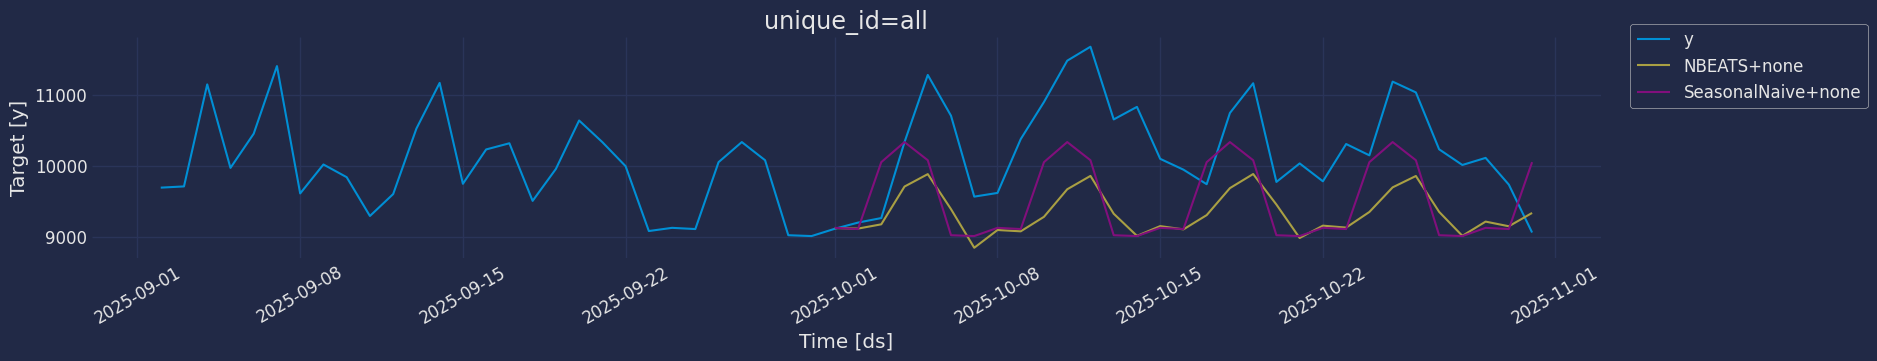

In [399]:
current_model = "NBEATS+none"
baseline = "SeasonalNaive+none"
plot_series(
    pl.concat([dfs["train"]["non"].filter(pl.col("ds") > pl.lit("2025-09-01").str.to_date()), dfs["val"]["non"]]).group_by(pl.col("ds")).agg(pl.col("y").sum()).with_columns(pl.lit("all").alias("unique_id")), # type: ignore
    pred_df_wide.drop("y"
                      ).select(["unique_id", "ds"]+[x for x in pred_df_wide.columns if (current_model == x or baseline in x)]
                      ).group_by(pl.col("ds")
                      ).agg(pl.col(current_model).sum(), pl.col(baseline).sum()
                      ).with_columns(pl.lit("all").alias("unique_id"))
)

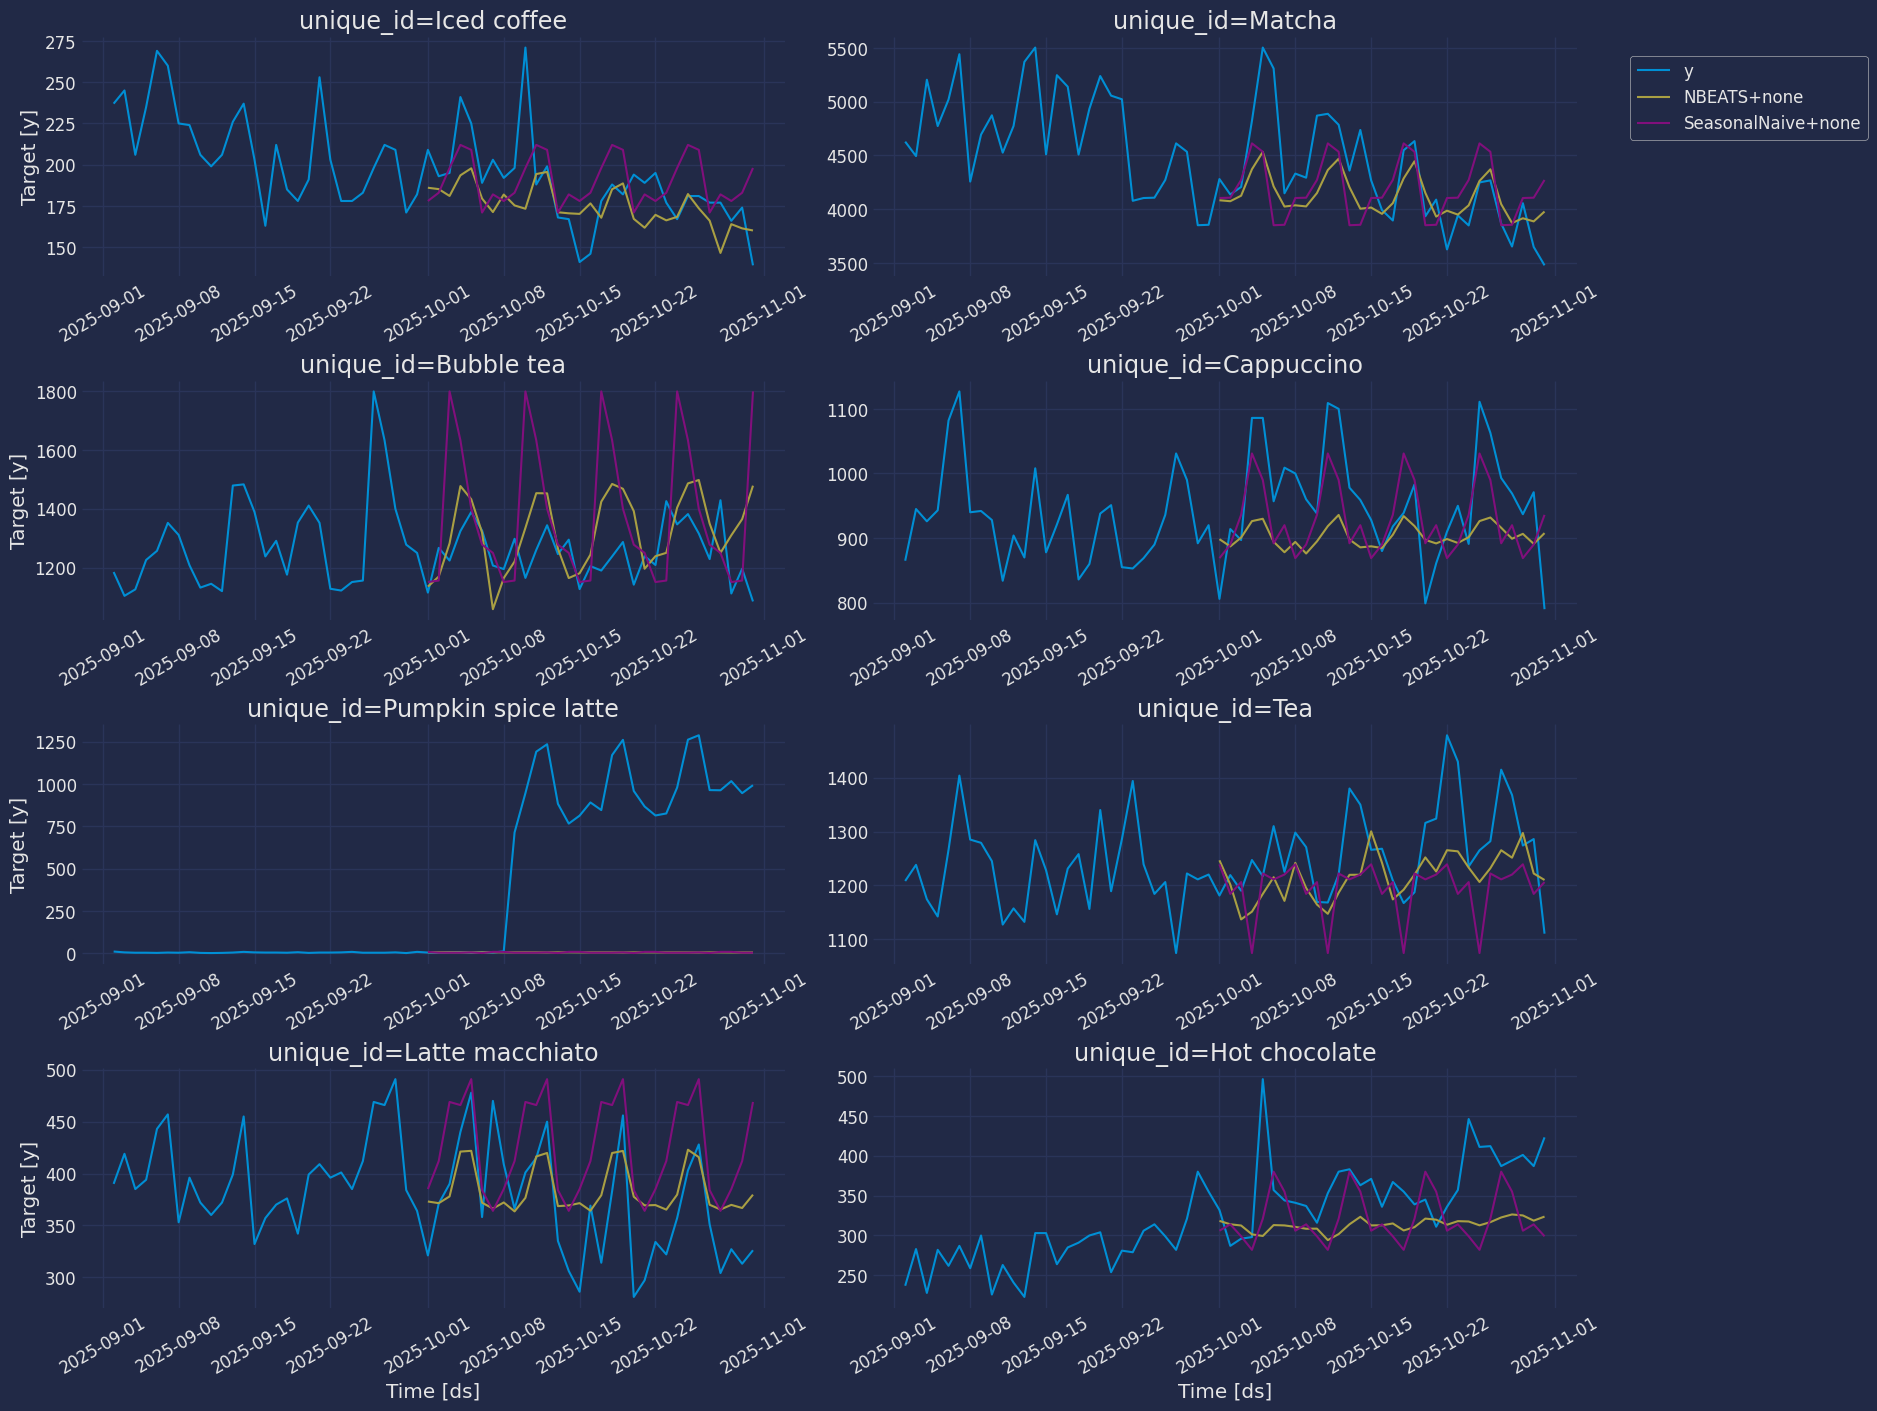

In [401]:
plot_series(
    pl.concat([dfs["train"]["non"].filter(pl.col("ds") > pl.lit("2025-09-01").str.to_date()), dfs["val"]["non"]]),# type: ignore
    pred_df_wide.drop("y").select(["unique_id", "ds"]+[x for x in pred_df_wide.columns if (current_model == x or baseline in x)])
)

## Fine tuning of Top Model

Top Models: NBEATS+none but NHits is just NBeats but newer so we'll tune an NHits model

### Tunning NHITS on the none dataset

In [ ]:
from neuralforecast.auto import AutoNHITS #improved version of NBeats
from neuralforecast.losses.pytorch import MAE
import optuna

In [515]:
# For potential manual tunging
h = HORIZON
ins = h*12
ms = 2000
factor = 2

nbeats_params = {
    "h": h,
    "input_size": ins,
    "loss": HuberLoss(),
    "max_steps": ms,
    "enable_model_summary": False,
    "enable_checkpointing": False,
    "logger": False,
    "accelerator": "gpu",
    "devices": 1,
    "batch_size": 64,
    "learning_rate": 1e-4,
    "n_blocks": [1]*factor,
    "stack_types": ["identity"]*factor,
    "mlp_units": [[256, 256]]*factor
}

dl_models =[
 NHITS  (**nbeats_params), #type: ignore
 NBEATS (**nbeats_params),#type: ignore
]

Seed set to 1
Seed set to 1


In [ ]:
h = HORIZON
ms = 1000
factor = 2

def nhits_config(trial):
    return {
        # ints
        "input_size": trial.suggest_int("input_size", h*3, h * 24, log=True),
        "max_steps": trial.suggest_int("max_steps", ms, ms * 2, log=True),
        # float
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        # cats
        "n_pool_kernel_size": trial.suggest_categorical("n_pool_kernel_size", [
            (2, 2, 2), (16, 8, 1), (4, 4, 4)
        ]),
        "n_freq_downsample": trial.suggest_categorical("n_freq_downsample", [
            (168, 24, 1), (24, 12, 1)
        ]),
        
        # conts
        "batch_size": 128,
        "windows_batch_size": 128,
        
        # Complex structures
        "mlp_units": trial.suggest_categorical("mlp_units", [
            [(64, 64, 64, 64)] * factor * 2,
            [(64, 64, 64, 64)] * factor,
            [(128, 128, 128 )] * factor,
            [(256, 256      )] * factor,
            [(512, 512      )] * factor
        ])
    }
    # {
    # "input_size": trial.loguniform(ins, ins*48),      # Try two different lookback windows
    # "max_steps": tune.loguniform(ms, ms*2),           # Try different training lengths
    # "learning_rate": tune.loguniform(1e-4, 1e-2),   # Pick a value in this range
    # "n_pool_kernel_size": tune.choice([(2, 2, 2), (16, 8, 1), (4,4,4)]), 
    # "n_freq_downsample": tune.choice([(168, 24, 1), (24, 12, 1)]),
    # "batch_size": [128],
    # 'windows_batch_size': [128],
    # "mlp_units": tune.choice([ [[64,64,64,64]]*factor*2, [[64,64,64,64]]*factor, [[128,128,128]]*factor, [[256, 256]]*factor, [[512, 512]]*factor])
    # }

dl_models =[
 AutoNHITS(h, loss=MAE(),backend="optuna", num_samples=50, config=nhits_config)
]

In [547]:
nf = NeuralForecast(
    models = dl_models,
    freq = "1d",
    local_scaler_type="robust"
)

def predict_with_DL_models(train_set: pl.DataFrame, future_features: pl.DataFrame|None, h: int = HORIZON)-> pl.DataFrame:
    nf.fit(train_set) # type: ignore
    preds = nf.predict(h = h, futr_df=future_features) #type: ignore
    return preds #type: ignore

In [ ]:
dl_tuned = predict_with_DL_models(dfs["train"]["non"], dfs["train_future"]["non"])#type: ignore
dl_tuned = dl_tuned.join(
    dfs["val"]["non"], #type: ignore
    ["unique_id", "ds"]
)

In [549]:
nf.models[0].results.best_params

{'input_size': 527,
 'max_steps': 1131,
 'learning_rate': 0.00015896348720777535,
 'n_pool_kernel_size': (16, 8, 1),
 'n_freq_downsample': (168, 24, 1),
 'mlp_units': [(256, 256), (256, 256)]}

In [550]:
metrics_tuned: pl.DataFrame = evaluate(
    dl_tuned,
    metrics=[mae, mape, rmse], # List the metrics you want
)
metrics_tuned.group_by(["metric"]).agg(pl.col("AutoNHITS").mean()).sort("metric")

metric,AutoNHITS
str,f64
"""mae""",141.203185
"""mape""",0.188644
"""rmse""",175.29123


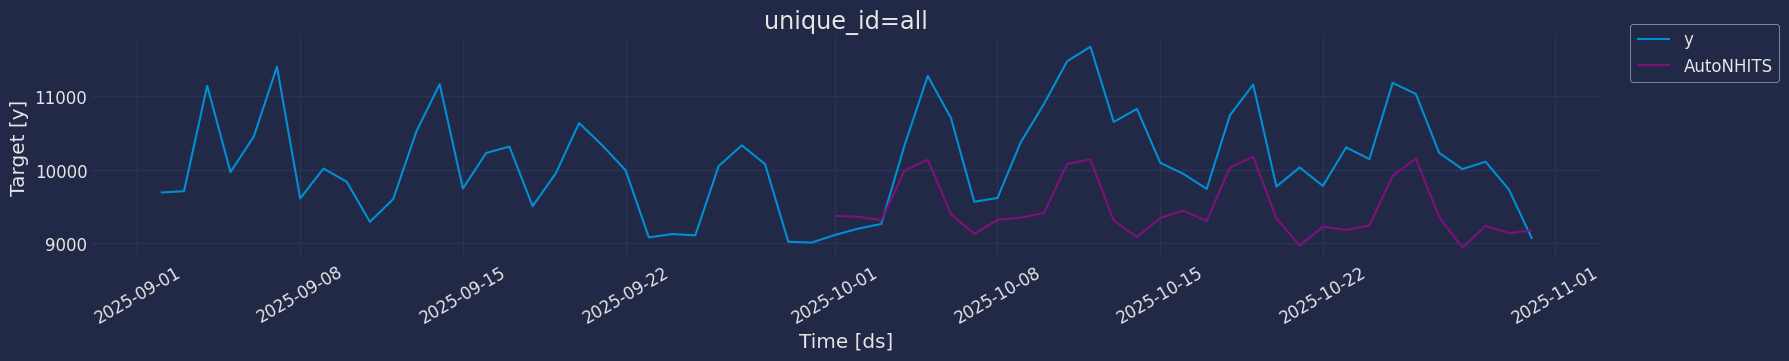

In [551]:
plot_series(
    pl.concat([dfs["train"]["non"].filter(pl.col("ds") > pl.lit("2025-09-01").str.to_date()), dfs["val"]["non"]] #type: ignore
    ).group_by(pl.col("ds")).agg(pl.col("y").sum()
    ).with_columns(pl.lit("all").alias("unique_id")), # type: ignore
    dl_tuned.drop("y").group_by(pl.col("ds")
                      ).agg(pl.col("AutoNHITS").sum()
                      ).with_columns(pl.lit("all").alias("unique_id"))
)

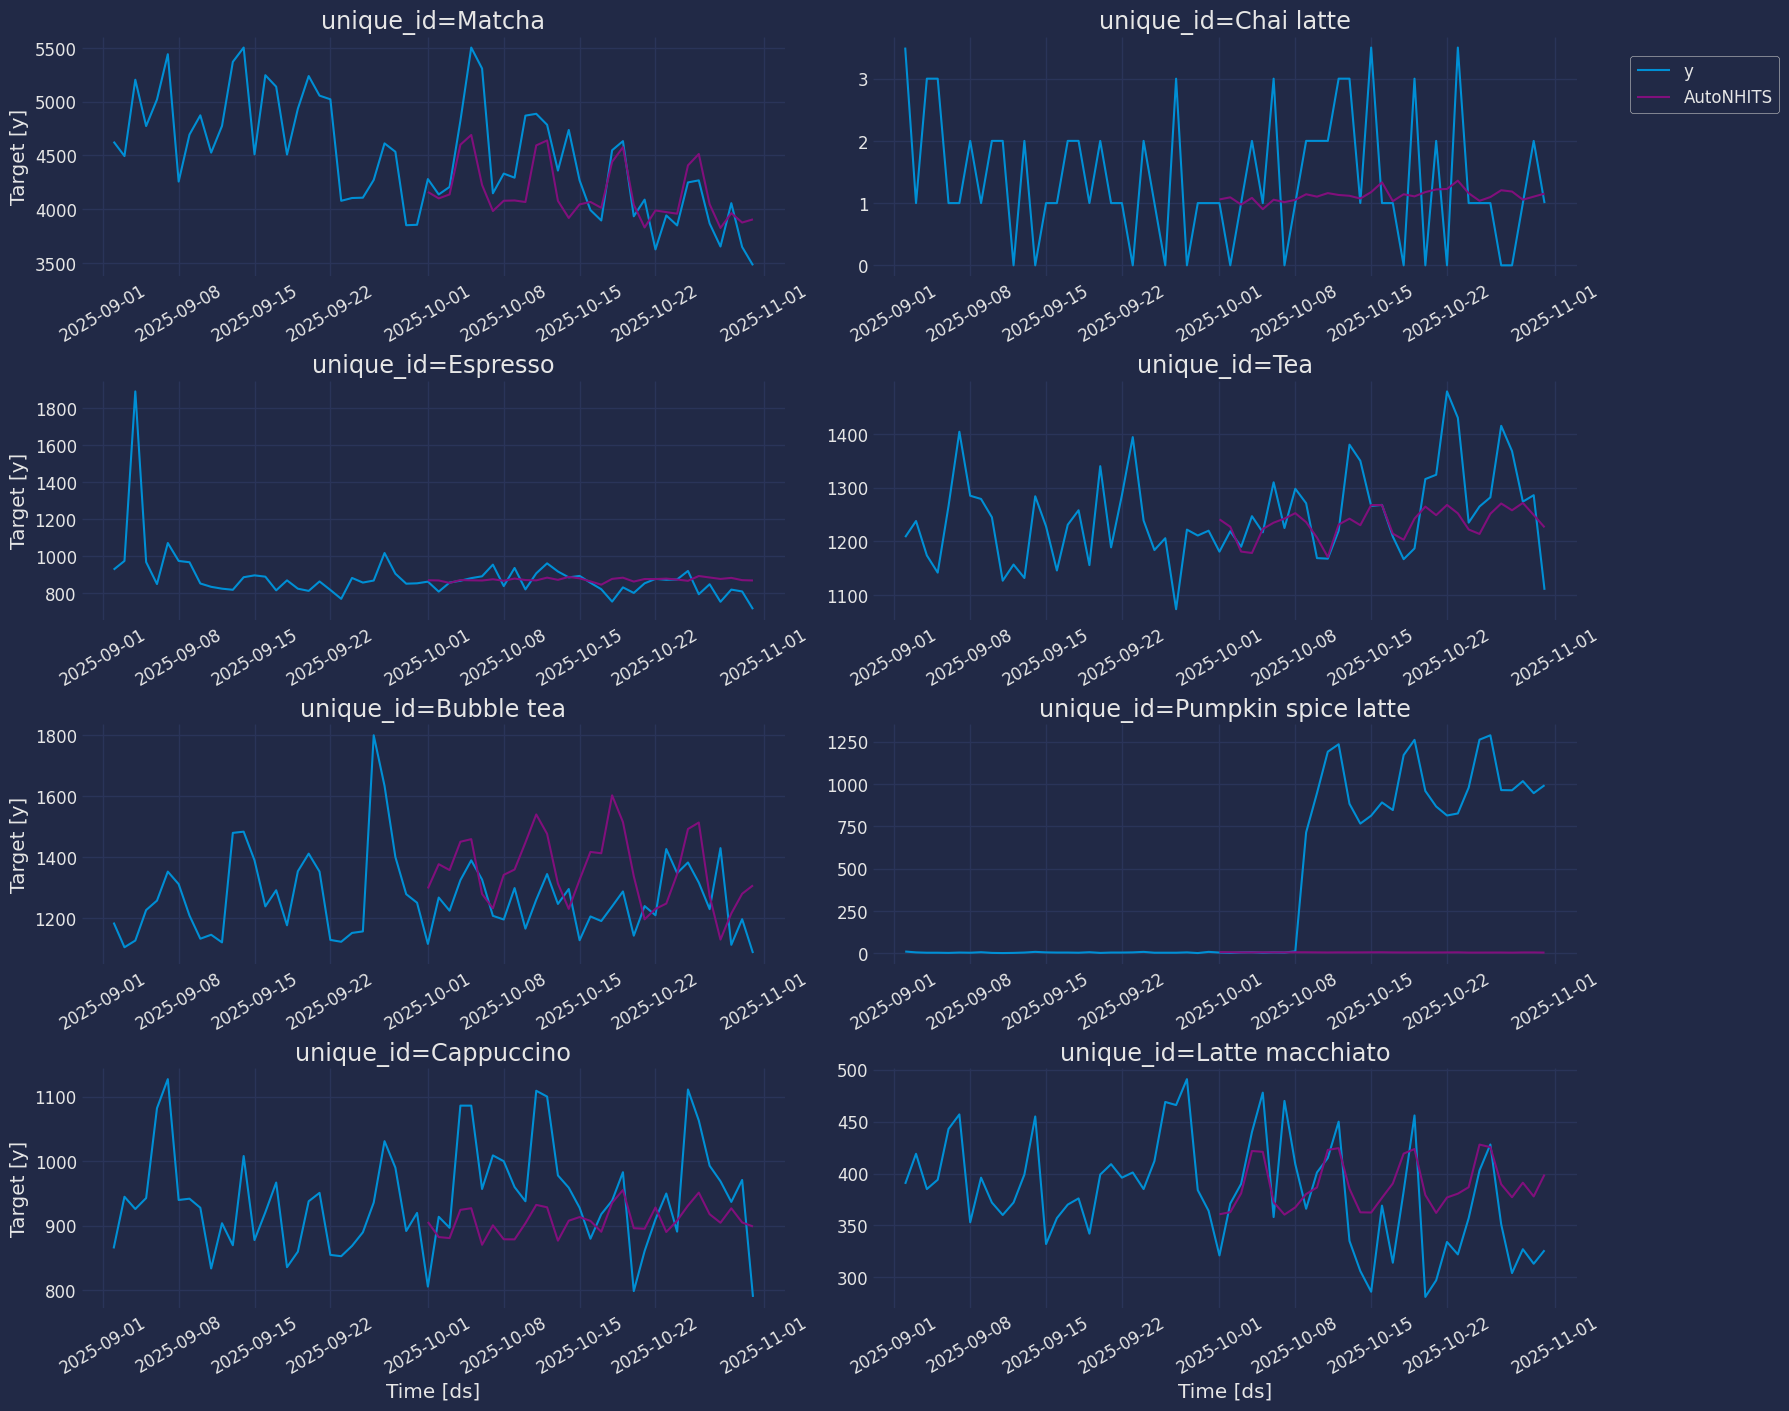

In [553]:
plot_series(
    pl.concat([dfs["train"]["non"].filter(pl.col("ds") > pl.lit("2025-09-01").str.to_date()), dfs["val"]["non"]]).sort("unique_id"), # type: ignore
    dl_tuned.drop("y")
)

## Evalute Final Model

Params 
```text
{'input_size': 527,
 'max_steps': 1131,
 'learning_rate': 0.00015896348720777535,
 'n_pool_kernel_size': (16, 8, 1),
 'n_freq_downsample': (168, 24, 1),
 'mlp_units': [(256, 256), (256, 256)]}
```

In [554]:
512/HORIZON

14.628571428571428

In [561]:
h = HORIZON
ins = h*18
ms = 1200

nbeats_params = {
    "h": h,
    "input_size": ins,
    "loss": HuberLoss(),
    "max_steps": ms,
    "enable_model_summary": False,
    "enable_checkpointing": False,
    "logger": False,
    "accelerator": "gpu",
    "devices": 1,
    "batch_size": 128,
    "learning_rate": 1589e-7,
    "mlp_units": [[256, 256]]*2,
    'n_pool_kernel_size': (16, 8, 1),
    'n_freq_downsample': (168, 24, 1),
}

dl_models =[
 NHITS  (**nbeats_params), #type: ignore
]

Seed set to 1


In [565]:
nf_final = NeuralForecast(
    models = dl_models,
    freq = "1d",
    local_scaler_type="robust"
)

def predict_with_DL_models(train_set: pl.DataFrame, future_features: pl.DataFrame|None, h: int = HORIZON)-> pl.DataFrame:
    nf_final.fit(train_set) # type: ignore
    preds = nf_final.predict(h = h, futr_df=future_features) #type: ignore
    return preds #type: ignore

In [566]:
train_set = pl.concat([dfs["train"]["non"], dfs["val"]["non"]])#type: ignore


test_pred = predict_with_DL_models(train_set, dfs["val_future"]["non"])#type: ignore
test_pred = test_pred.join(
    dfs["test"]["non"], #type: ignore
    ["unique_id", "ds"]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [573]:
base_model_test = predict_with_stats_model(train_set,dfs["val_future"]["non"], base_models) # type: ignore
base_model_test

unique_id,ds,SeasonalNaive
str,date,f64
"""Bubble tea""",2025-11-01,1382.0
"""Bubble tea""",2025-11-02,1316.0
"""Bubble tea""",2025-11-03,1229.0
"""Bubble tea""",2025-11-04,1429.0
"""Bubble tea""",2025-11-05,1112.0
…,…,…
"""Tea""",2025-12-01,1415.0
"""Tea""",2025-12-02,1368.0
"""Tea""",2025-12-03,1274.0


In [575]:
metrics_final: pl.DataFrame = evaluate(
    test_pred.join(base_model_test, on=["unique_id", "ds"]),
    metrics=[mae, mape, rmse], # List the metrics you want
)
metrics_final.group_by(["metric"]).agg(pl.col("NHITS").mean(), pl.col("SeasonalNaive").mean()).sort("metric")

metric,NHITS,SeasonalNaive
str,f64,f64
"""mae""",150.933341,171.024286
"""mape""",0.328873,0.406559
"""rmse""",170.175105,194.208998


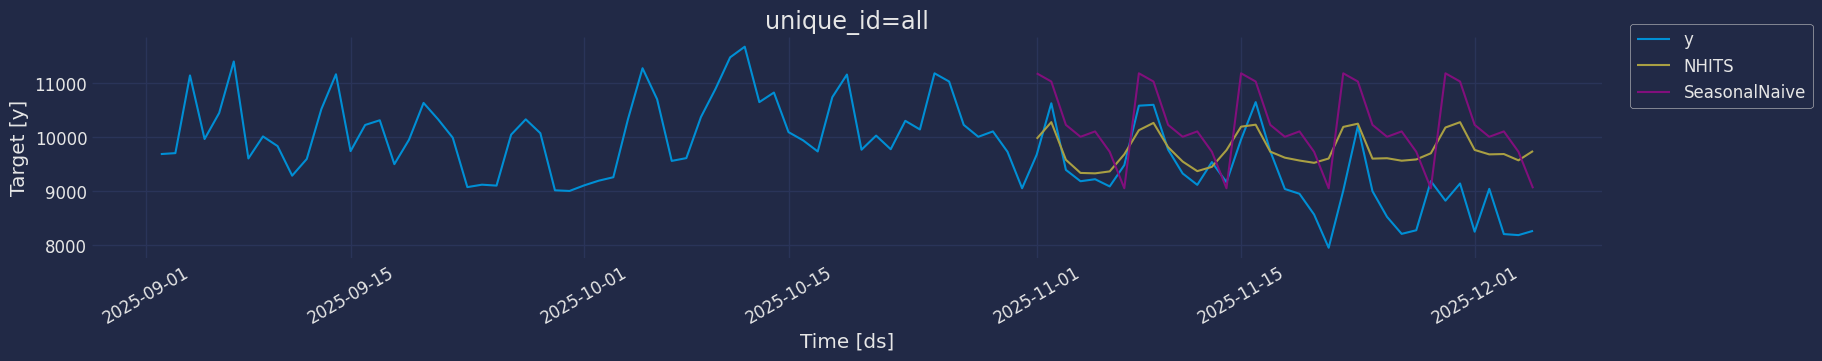

In [584]:
plot_series(
    pl.concat([train_set.filter(pl.col("ds") > pl.lit("2025-09-01").str.to_date()), dfs["test"]["non"].filter(pl.col("ds") < pl.lit("2025-12-06").str.to_date())] #type: ignore
    ).group_by(pl.col("ds")).agg(pl.col("y").sum()
    ).with_columns(pl.lit("all").alias("unique_id")), # type: ignore
    test_pred.drop("y").join(
        base_model_test, on=["unique_id", "ds"]
        ).group_by(pl.col("ds")
                      ).agg(pl.col("NHITS").sum(), pl.col("SeasonalNaive").sum()
                      ).with_columns(pl.lit("all").alias("unique_id"))
)

In [586]:
to_export = test_pred.join(base_model_test, on=["unique_id", "ds"]).select(["unique_id", "ds", "y", "NHITS", "SeasonalNaive"])
to_export.write_parquet(EXPORT_FOLDER+"../final_model_test_set_eval.parquet")
to_export

unique_id,ds,y,NHITS,SeasonalNaive
str,date,f64,f32,f64
"""Bubble tea""",2025-11-01,1148.0,1240.802246,1382.0
"""Bubble tea""",2025-11-02,1095.0,1244.346802,1316.0
"""Bubble tea""",2025-11-03,1097.0,1145.119629,1229.0
"""Bubble tea""",2025-11-04,1089.0,1186.418701,1429.0
"""Bubble tea""",2025-11-05,1218.0,1124.537842,1112.0
…,…,…,…,…
"""Tea""",2025-12-01,1527.0,1030.158691,1415.0
"""Tea""",2025-12-02,1589.0,1073.812012,1368.0
"""Tea""",2025-12-03,1407.0,1068.509033,1274.0


In [582]:
metrics_final.group_by(["metric"]).agg(pl.col("NHITS").mean(), pl.col("SeasonalNaive").mean()).sort("metric").to_pandas().to_markdown("./metrics.md")